## 소상공인시장진흥공단 상가업소정보로 스타벅스, 이디야 위치 분석하기

* 이디야는 스타벅스 근처에 입점한다는 설이 있습니다. 과연 이디야와 스타벅스의 매장입지는 얼마나 차이가 날까요? 관련 기사를 읽고 구별로 이디야와 스타벅스의 매장을 기사와 유사하게 분석하고 시각화 해보면서 Python, Pandas, Numpy, Seaborn, Matplotlib, folium 을 통해 다양한 방법으로 표현해 봅니다..

### 다루는 내용
* 텍스트 데이터 정제하기 -  대소문자로 섞여있는 상호명을 소문자로 변경하고 상호명 추출하기
* 텍스트 데이터에서 원하는 정보 추출하기 - 브랜드명 컬럼을 만들고 구별 매장 수 분석하기
* folium을 통한 위경도 데이터 시각화 - CircleMarker와 choropleth 그리기

## 필요한 라이브러리 불러오기

In [1]:
# 데이터 분석을 위해 pandas를, 수치계산을 위해 numpy를, 시각화를 위해 seaborn을 불러옵니다.
import pandas as pd
import numpy as np
import seaborn as sns

# 구버전의 주피터 노트북에서 그래프가 보이는 설정
# %matplotlib inline

## 시각화를 위한 한글 폰트 설정하기

In [2]:
# 한글폰트 설정
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [3]:
# 폰트가 선명하게 보이도록 retina 설정
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## 데이터 불러오기
* 공공데이터 포털 : https://www.data.go.kr/dataset/15012005/fileData.do

In [4]:
df = pd.read_csv('data/상가업소정보_201912_01.csv', sep='|')
df.shape

(573680, 39)

### 결측치 보기

In [5]:
df.isnull().sum()

상가업소번호            0
상호명               1
지점명          497006
상권업종대분류코드         0
상권업종대분류명          0
상권업종중분류코드         0
상권업종중분류명          0
상권업종소분류코드         0
상권업종소분류명          0
표준산업분류코드      34390
표준산업분류명       34390
시도코드              0
시도명               0
시군구코드             0
시군구명              0
행정동코드             0
행정동명              0
법정동코드             0
법정동명              0
지번코드              0
대지구분코드            0
대지구분명             0
지번본번지             0
지번부번지         98756
지번주소              0
도로명코드             0
도로명               0
건물본번지             0
건물부번지        501692
건물관리번호            0
건물명          308072
도로명주소             0
구우편번호             0
신우편번호             9
동정보          522824
층정보          226553
호정보          488414
경도                0
위도                0
dtype: int64

In [6]:
columns = ['상호명', '상권업종대분류명', '상권업종중분류명', '상권업종소분류명', 
           '시도명', '시군구명', '행정동명', '법정동명', '도로명주소', 
           '경도', '위도']

df = df[columns].copy()
df.shape

(573680, 11)

## 색인으로 서브셋 가져오기

In [7]:
df_seoul = df[df['시도명']=='서울특별시'].copy()

### 일부 텍스트가 들어가는 데이터만 가져오기
* 상호명에서 브랜드명을 추출합니다.
* 대소문자가 섞여 있을 수도 있기 때문에 대소문자를 변환해 줍니다.
* 오타를 방지하기 위해 스타벅스의 영문명은 STARBUCKS, 이디야는 EDIYA 입니다.

* https://pandas.pydata.org/docs/user_guide/text.html#testing-for-strings-that-match-or-contain-a-pattern

In [8]:
# 문자열의 소문자로 변경하는 메소드를 사용합니다.
# "상호명_소문자" 컬럼을 만듭니다.

df_seoul['상호명_소문자'] = df_seoul['상호명'].str.lower()
df_seoul['상호명_소문자']

0                와라와라호프
1         커피빈코리아선릉로93길점
2                  프로포즈
4              가락사우나내스낵
5                   초밥왕
              ...      
573675          비파티세리공덕
573676            앤탑pc방
573677         오즈아레나pc방
573678           파인트리네일
573679           마이리틀네일
Name: 상호명_소문자, Length: 407376, dtype: object

In [9]:
# ediya 를 "상호명_소문자" 컬럼으로 가져옵니다.
# '상호명_소문자'컬럼으로 '이디야|ediya' 를 가져와 갯수를 세어봅니다.
# loc[행]
# loc[행, 열]
df_seoul.loc[df_seoul['상호명_소문자'].str.contains('이디야|이디아|ediya'), '상호명_소문자'].shape

(543,)

In [10]:
# 상호명에서 스타벅스만 가져옵니다.
# 상호명은 소문자로 변경해 준 컬럼을 사용합니다.
# 스타벅스|starbucks 의 "상호명_소문자"로 갯수를 세어봅니다.
df_seoul.loc[df_seoul['상호명_소문자'].str.contains('스타벅스|starbucks'), '상호명_소문자'].shape

(506,)

In [11]:
# '상호명_소문자'컬럼으로  '스타벅스|starbucks|이디야|이디아|ediya'를 가져와 df_cafe 변수에 담습니다.
df_cafe = df_seoul[df_seoul['상호명_소문자'].str.contains('스타벅스|starbucks|이디야|이디아|ediya')].copy()
df_cafe.shape

(1049, 12)

In [12]:
# ~은 not을 의미합니다. 스타벅스가 아닌 데이터는 이디야로 넣어주어도 되지만
# 아래 코드처럼 결측치를 이디야로 채워줘도 괜찮습니다.
# df_cafe.loc[~df_cafe['상호명'].str.contains('스타벅스|starbucks'), '브랜드명'] = '이디야'

df_cafe.loc[df_cafe['상호명'].str.contains('스타벅스|starbucks'), '브랜드명'] = '스타벅스'
# df_cafe.loc[~df_cafe['상호명'].str.contains('스타벅스|starbucks'), '브랜드명'] = '이디야'
df_cafe[['상호명', '브랜드명']]

,상호명,브랜드명
1104,스타벅스,스타벅스
1675,이디야커피,NaN
2023,스타벅스종로3가점,스타벅스
2770,스타벅스,스타벅스
2957,이디야커피,NaN
...,...,...
567090,스타벅스,스타벅스
567828,스타벅스,스타벅스
568636,이디야커피,NaN
570096,스타벅스,스타벅스


In [13]:
# 스타벅스를 제외한 데이터는 이디야이기 때문에 이디야로 브랜드명을 만듭니다.
df_cafe["브랜드명"] = df_cafe["브랜드명"].fillna("이디야")
df_cafe["브랜드명"].head()

1104    스타벅스
1675     이디야
2023    스타벅스
2770    스타벅스
2957     이디야
Name: 브랜드명, dtype: object

### 시각화
#### 분류별 countplot 그리기

In [14]:
# "상권업중분류명"을 countplot 으로 시각화하고 분류 혹은 데이터가 잘못 색인된 데이터가 있는지 봅니다.
df_cafe['상권업종중분류명'].value_counts()

커피점/카페       1036
학원-어학           3
광고/인쇄           2
분양              1
주택수리            1
기타판매업           1
운동/경기용품소매       1
패스트푸드           1
유흥주점            1
주유소/충전소         1
종합소매점           1
Name: 상권업종중분류명, dtype: int64

In [15]:
print(df_cafe.shape)
df_cafe = df_cafe[df_cafe['상권업종중분류명']=='커피점/카페'].copy()
print(df_cafe.shape)

(1049, 13)
(1036, 13)


In [16]:
# 브랜드명으로 각 카페의 갯수를 세어봅니다.
df_cafe['브랜드명'].value_counts()

이디야     533
스타벅스    503
Name: 브랜드명, dtype: int64

<AxesSubplot:xlabel='브랜드명', ylabel='count'>

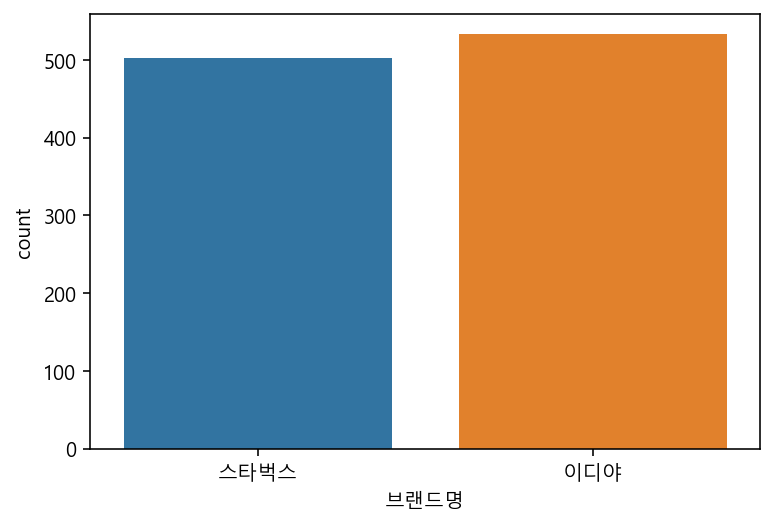

In [17]:
# 브랜드명을 막대그래프로 그려봅니다.
sns.countplot(data=df_cafe, x='브랜드명')

<AxesSubplot:xlabel='시군구명', ylabel='count'>

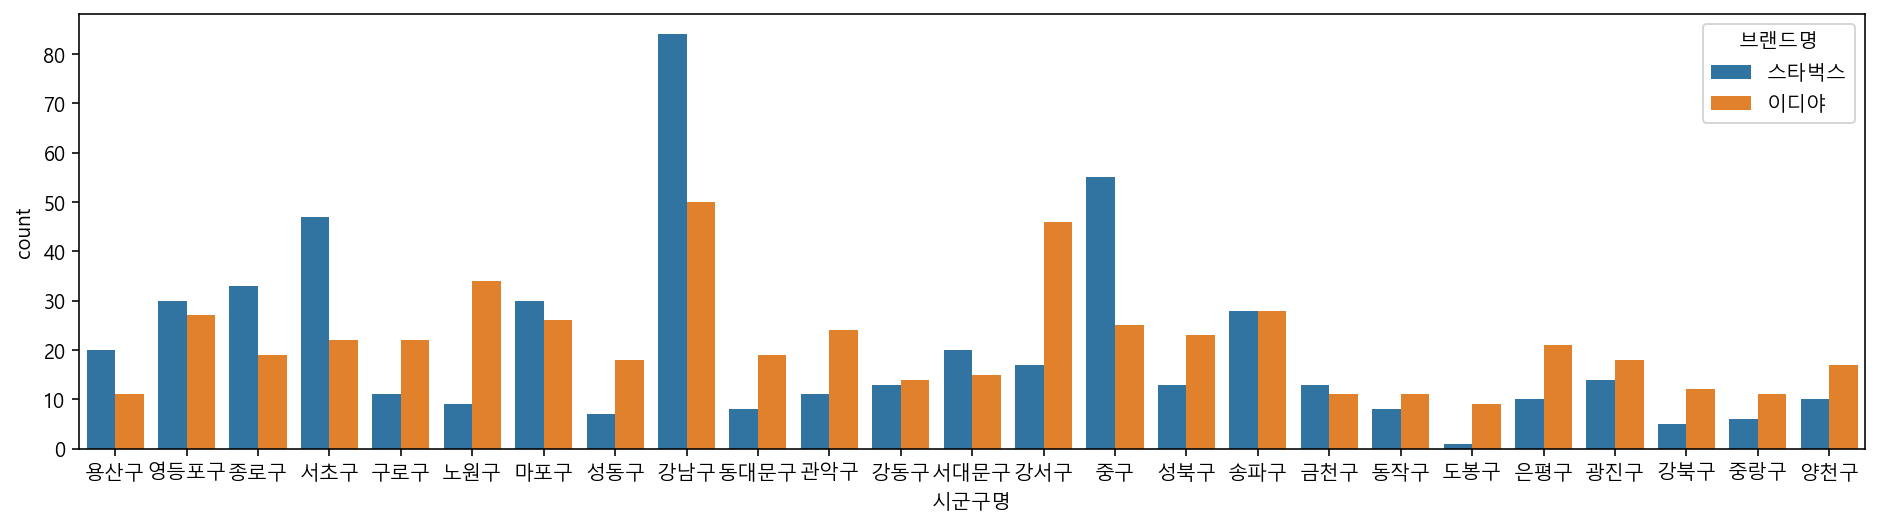

In [18]:
plt.figure(figsize=(16,4))
sns.countplot(data=df_cafe, x='시군구명', hue='브랜드명')

#### scatterplot 그리기
* https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#scatter-plot

<AxesSubplot:xlabel='경도', ylabel='위도'>

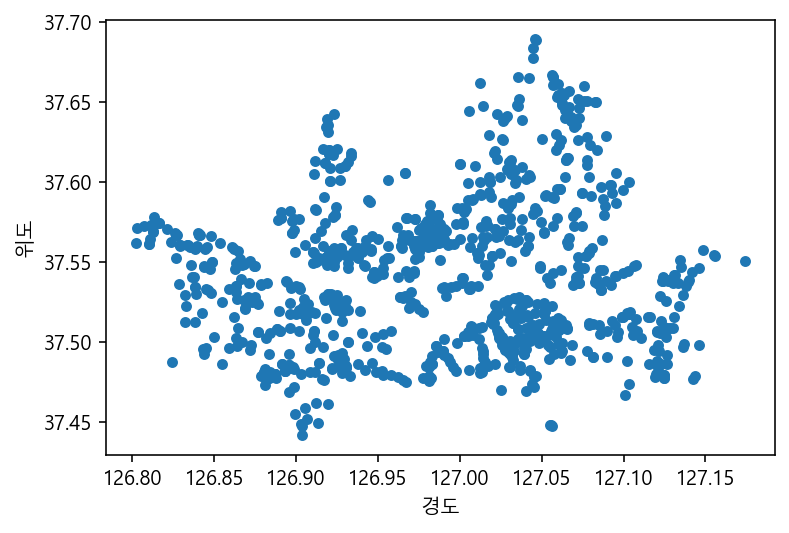

In [19]:
# pandas로 scatterplot을 그려봅니다.
df_cafe[['위도', '경도']].plot.scatter(x='경도', y='위도')

<AxesSubplot:xlabel='경도', ylabel='위도'>

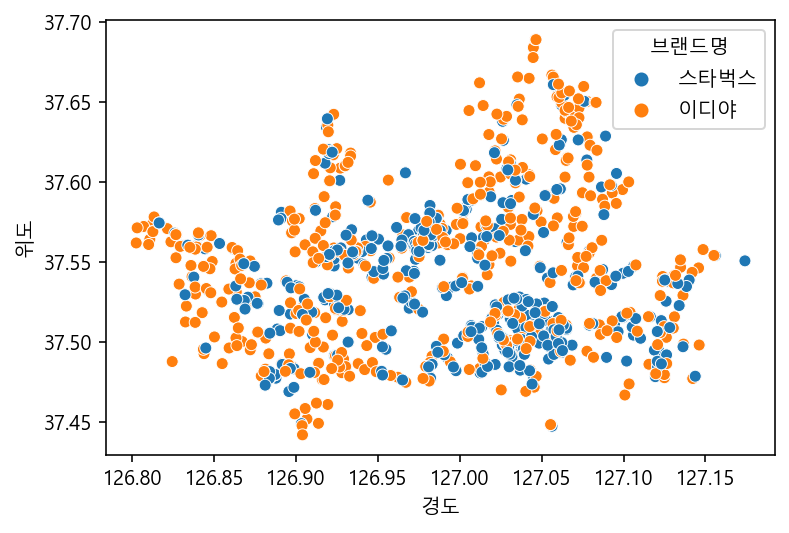

In [20]:
# seaborn의 scatterplot 으로 hue에 브랜드명을 지정해서 시각화 합니다.
sns.scatterplot(data=df_cafe, x='경도', y='위도', hue='브랜드명')

#### jointplot 그리기

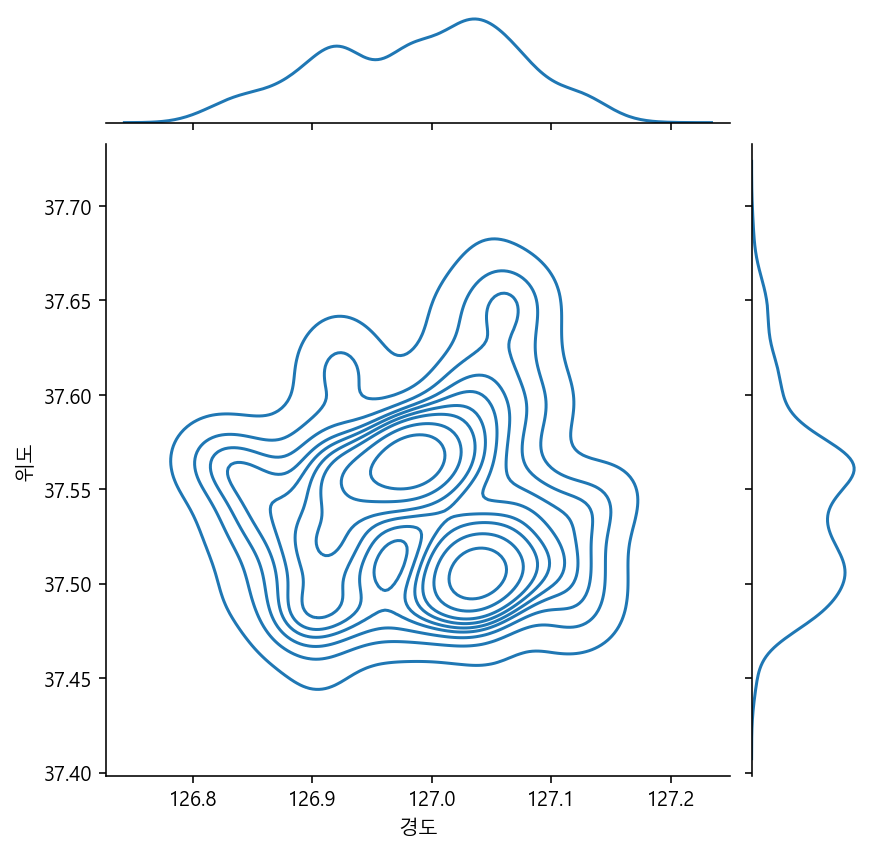

In [21]:
# jointplot 그리기
sns.jointplot(data=df_cafe, x='경도', y='위도', kind='kde')

## 구별 브랜드별 점포수
### groupby 와 pivot_table 로 구별 스타벅스, 이디야 매장 수 구하기
#### groupby 로 구별 매장수 구하기

In [22]:
# 구별로 브랜드별 점포수를 구합니다.
# groupby 를 사용하면 구별로 그룹화 해서 점포수를 구할 수 있습니다.
# 그룹화한 결과를 df_cafe_vs 변수에 담아서 재사용합니다.

df_cafe_vs = df_cafe.groupby(['시군구명', '브랜드명'])['상호명'].count() #어떤 칼럼이든 수 같으니까 아무거나 '상호명'지정
df_cafe_vs.head()

시군구명  브랜드명
강남구   스타벅스    84
      이디야     50
강동구   스타벅스    13
      이디야     14
강북구   스타벅스     5
Name: 상호명, dtype: int64

In [23]:
#to_frame() 사용. - 멀티인덱스가 생김
df_cafe_vs.to_frame().head()

상호명
시군구명 브랜드명     
강남구  스타벅스   84
     이디야    50
강동구  스타벅스   13
     이디야    14
강북구  스타벅스    5

In [24]:
# reset_index 로 인덱스를 컬럼으로 만듭니다.
df_cafe_vs = df_cafe_vs.reset_index()
df_cafe_vs.head()

,시군구명,브랜드명,상호명
0,강남구,스타벅스,84
1,강남구,이디야,50
2,강동구,스타벅스,13
3,강동구,이디야,14
4,강북구,스타벅스,5


In [25]:
# groupby '시군구명', '브랜드명' 으로 갯수를 세어봅니다.
# 결과에 대한 데이터프레임 컬럼명을 ['구', '브랜드명', '매장수'] 로 지정합니다.
df_cafe_vs.columns = ['구', '브랜드명', '매장수']
df_cafe_vs.head(1)

,구,브랜드명,매장수
0,강남구,스타벅스,84


#### pivot_table 로 구별 매장수 구하기

In [26]:
# 위에서 했던 과정을 pivot_table 로 구합니다.

pivot = pd.pivot_table(data=df_cafe, 
               index=['시군구명', '브랜드명'], 
               values='상호명', aggfunc='count')
pivot.head()

상호명
시군구명 브랜드명     
강남구  스타벅스   84
     이디야    50
강동구  스타벅스   13
     이디야    14
강북구  스타벅스    5

In [27]:
# 특정 구 데이터만 가져와서 보기
pivot.loc['강남구']

,상호명
브랜드명,
스타벅스,84
이디야,50


### 막대그래프로 시각화 하기

<AxesSubplot:xlabel='구', ylabel='매장수'>

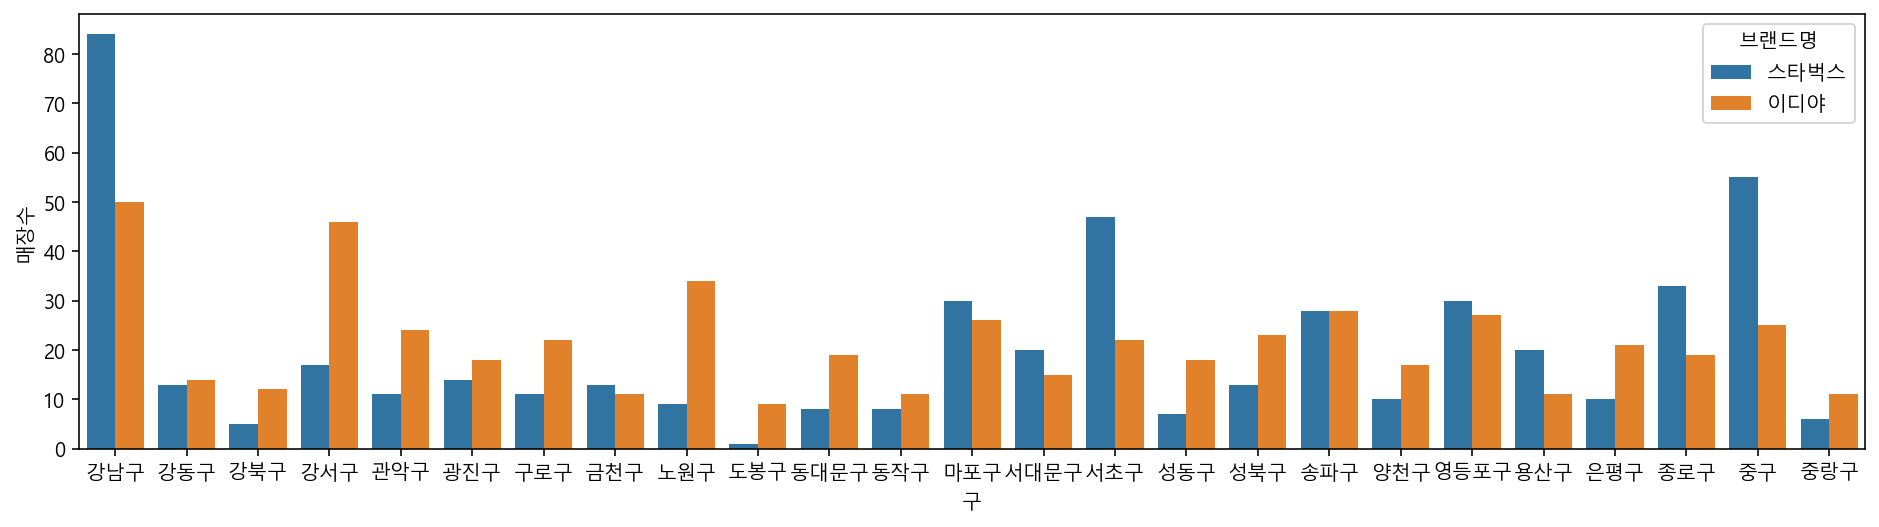

In [28]:
# seaborn의 barplot 을 활용해 구별 매장수를 시각화 합니다.
plt.figure(figsize=(16,4))
sns.barplot(data=df_cafe_vs, x='구', y='매장수', hue='브랜드명')

* 브랜드명을 컬럼으로 만들기
* unstack 이해하기 : https://pandas.pydata.org/docs/user_guide/reshaping.html

<AxesSubplot:xlabel='시군구명,브랜드명'>

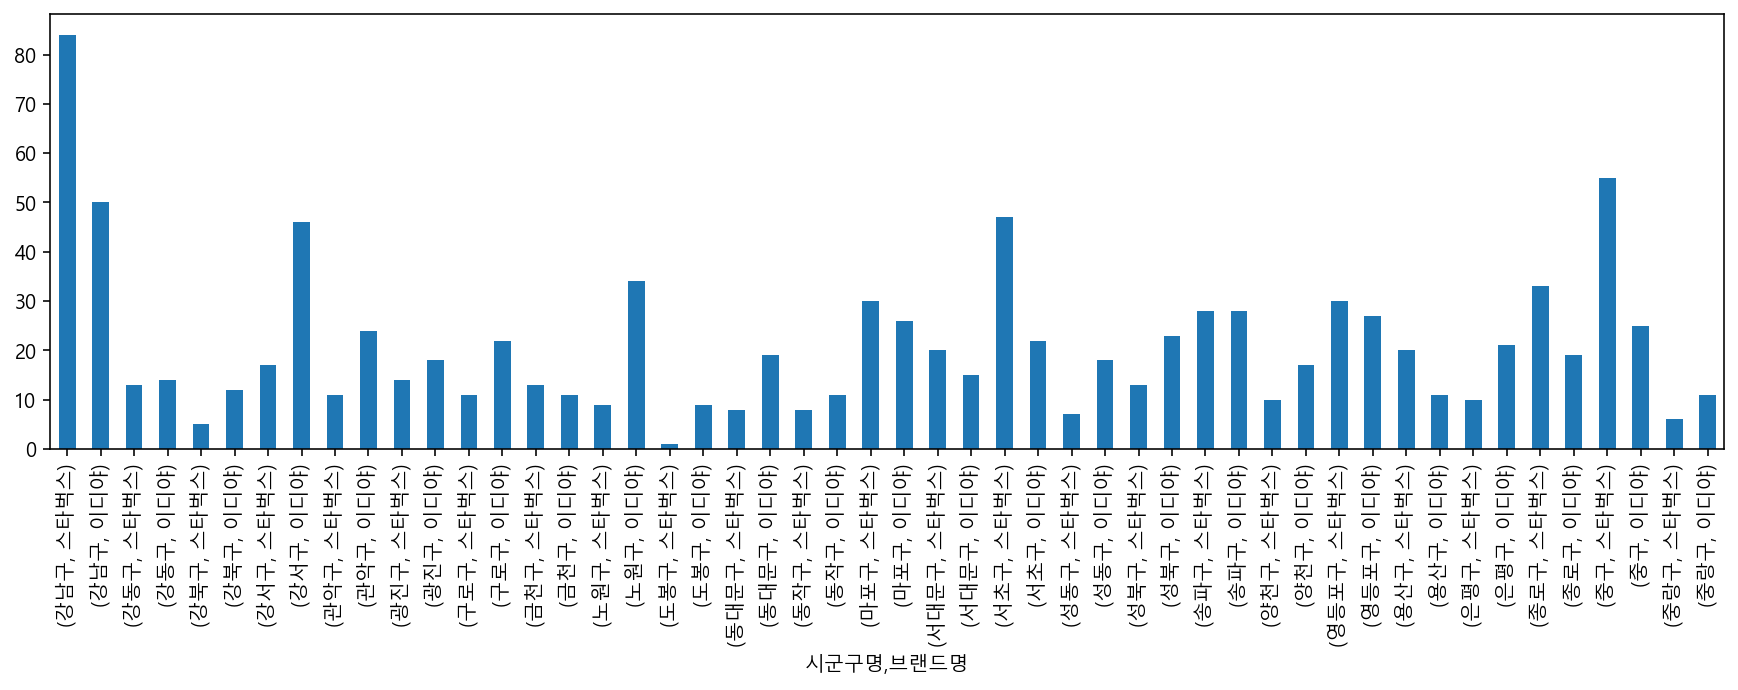

In [29]:
# groupby 를 통해 "시군구명", "브랜드명"으로 그룹화를 하고 "상호명"의 갯수를 세어봅니다.
# 갯수를 셀때는 count를 사용합니다.

group = df_cafe.groupby(['시군구명', '브랜드명'])['상호명'].count()
group.plot.bar(figsize=(15,4))

<AxesSubplot:xlabel='시군구명'>

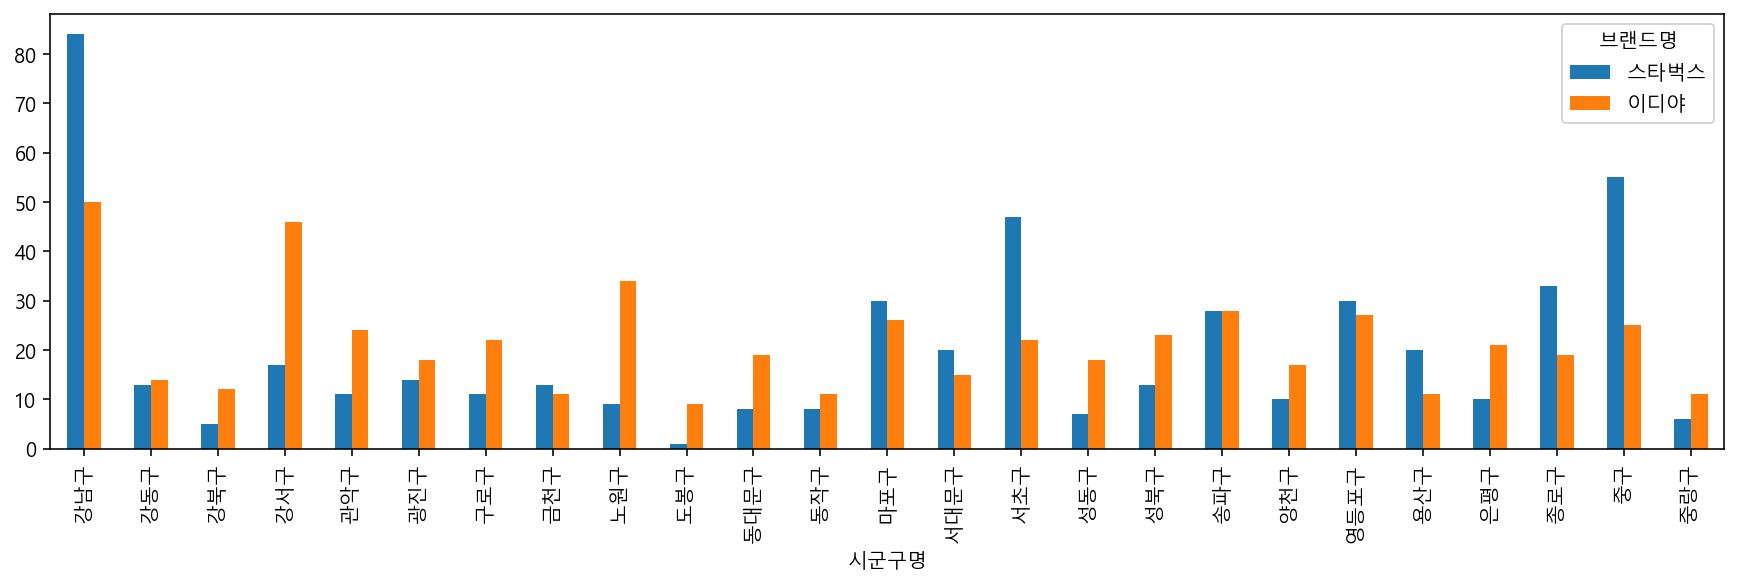

In [30]:
# 위에서 groupby 로 데이터를 집계한 결과를 시각화 합니다.

group.unstack().plot.bar(figsize=(15,4))

<AxesSubplot:xlabel='시군구명'>

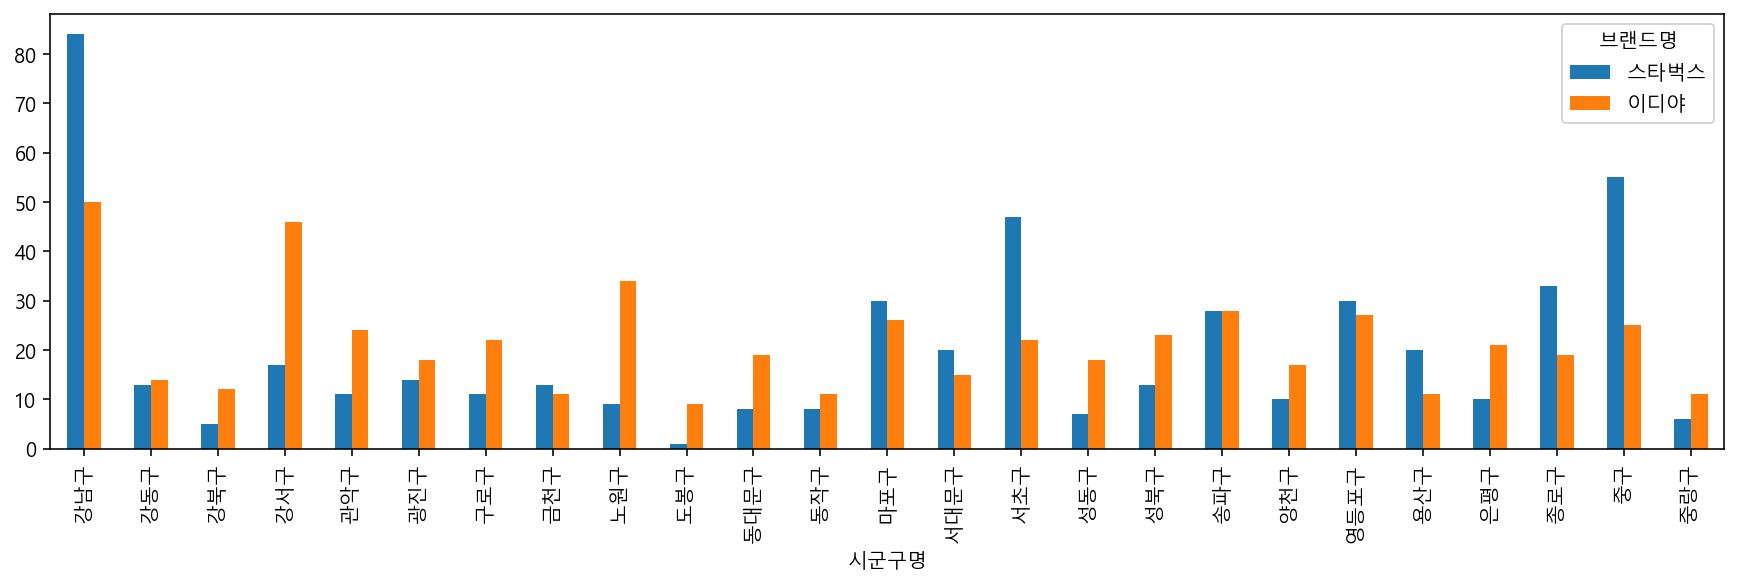

In [31]:
# pivot_table 을 이용해서 구별 스타벅스, 이디야 매장수를 구합니다.
pd.pivot_table(data=df_cafe, index='시군구명', columns='브랜드명', values='상호명', aggfunc='count').plot.bar(figsize=(15,4))
# 판다스의 장점 중 하나는 위에서처럼 구한 pivot_table을 시각화 해보기 쉽습니다.
# pivot_table 로 구한 결과를 plot.bar()를 통해 시각화 합니다.

<AxesSubplot:xlabel='시군구명', ylabel='count'>

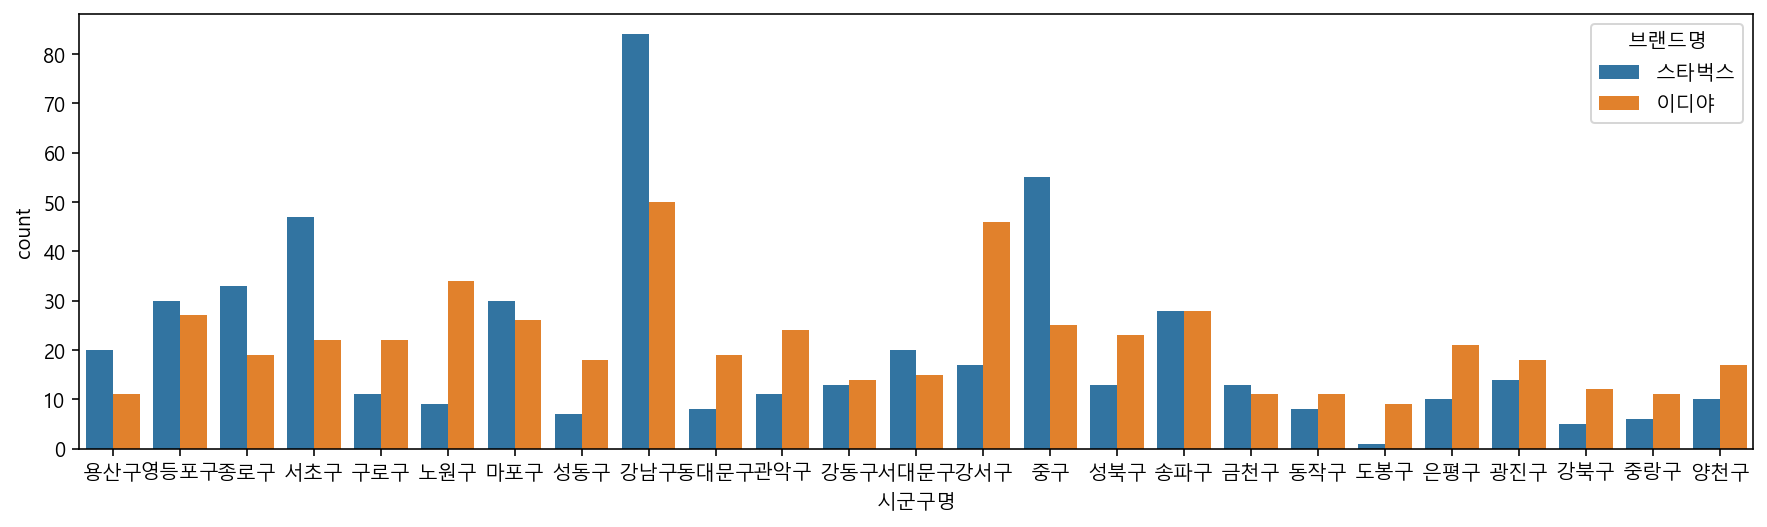

In [32]:
# Pandas 로 시각화를 하는 방법도 있지만 seaborn의 countplot을 사용하면 해당 컬럼의 수를 계산해서 시각화를 해줍니다.
# hue 옵션을 사용하게 되면 값에 따라 다른 색상으로 그리게 됩니다. 
# hue 옵션을 사용할 때는 2~3개 정도의 카테고리 형태의 데이터를 사용하는 것이 적합합니다.

plt.figure(figsize=(15,4))
sns.countplot(data=df_cafe, x='시군구명', hue='브랜드명')

## Folium 으로 지도 활용하기
### 스타벅스 이디야 카페 매장 전체 분포
* 스타벅스와 이디야 매장을 Marker와 CircleMarker로 지도에 표현합니다.

In [33]:
import folium

lat = df_cafe['위도'].mean()
long = df_cafe['경도'].mean()

m = folium.Map([lat, long], zoom_start=11, tiles='Stamentoner')

for i in df_cafe.index:
    sub_lat = df_cafe.loc[i, '위도']
    sub_long = df_cafe.loc[i, '경도']
    
    title = f"{df_cafe.loc[i, '상호명']} - {df_cafe.loc[i, '도로명주소']}"
    
    icon_color = 'blue'
    if df_cafe.loc[i, '브랜드명'] == '스타벅스':
        icon_color = 'green'
        
    folium.CircleMarker([sub_lat, sub_long], 
                    color=icon_color,
                    radius=3,
                    tooltip=title).add_to(m)

m
#스타벅스는 대부분 대로변, 이디야는 도로 안쪽에 위치하고 있음을 알 수 있다.

### choropleth 를 위한 GeoJSON 파일로드

In [48]:
# 서울의 행정구역 경계를 GeoJSON으로 표현한 파일입니다. 
# 이 파일을 불러와 구별 스타벅스와 이디야의 매장수를 표현합니다.
geo_path = 'data/seoul_municipalities_geo_simple.json'

import json
geo_json = json.load(open(geo_path, encoding="utf-8"))

### 스타벅스 매장 분포

In [49]:
df_star = df_cafe_vs[df_cafe_vs['브랜드명'] == '스타벅스'].copy()

In [36]:
# geo_json 에서 구 이름 가져오기
geo_json['features'][0]['properties']['name']

'강동구'

In [37]:
m = folium.Map([lat, long])

folium.Choropleth(
    geo_data=geo_json,
    name="choropleth",
    data=df_star,
    columns=["구", "매장수"],
    key_on="feature.properties.name",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="스타벅스 매장수",
).add_to(m)

m

### 이디야 매장 분포

In [38]:
df_ediya = df_cafe_vs[df_cafe_vs['브랜드명']=='이디야'].copy()

In [39]:
m = folium.Map([lat, long], tiles='Stamentoner')

folium.Choropleth(
    geo_data=geo_json,
    name="choropleth",
    data=df_ediya,
    columns=["구", "매장수"],
    key_on="feature.properties.name",
    fill_color="Blues",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="이디야 매장수",
).add_to(m)

m

### 매장수 크기를 반영해 CircleMaker 그리기
#### Pandas 의 reshaping data 활용하기

In [40]:
# df_vs 라는 변수에 구별 브랜드명을 pivot해서 스타벅스와 이디야 매장을 비교할 수 있는 형태로 만듭니다.
# 그리고 ["스타벅스", "이디야"] 로 컬럼명을 변경해주고 
# 스타벅스와 이디야의 매장을 비교한 값을 "매장수비교" 컬럼에 담아줍니다.

df_vs = df_cafe_vs.pivot(index='구', columns='브랜드명', values='매장수') #새로 만드는 거라 copy() 안 해도 됨
df_vs['매장수비교'] = df_vs['스타벅스'] - df_vs['이디야'] > 0

In [41]:
# 간단한 함수를 사용해서 스타벅스가 이디야보다 매장수가 많을 때 1을 출력하도록 합니다.
df_vs['매장수비교'] = df_vs['매장수비교'].astype(float) #나중에 choropleth그릴 때 radius에 float 입력해야하기 때문

In [42]:
df_vs = df_vs.reset_index()

### Choropleth 로 매장수의 많고 적음에 따라 표현하기

In [43]:
m = folium.Map([lat, long], tiles='Stamentoner')

folium.Choropleth(
    geo_data=geo_json,
    name="choropleth",
    data=df_vs,
    columns=["구", "매장수비교"],
    key_on="feature.properties.name",
    fill_color="BuGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="매장수 비교",
).add_to(m)

m

In [44]:
df_gu_mean = df_cafe.pivot_table(index='시군구명')
df_gu_mean = df_gu_mean.reset_index()
df_gu_mean.head()

,시군구명,경도,위도
0,강남구,127.046129,37.505744
1,강동구,127.135417,37.540316
2,강북구,127.022897,37.631146
3,강서구,126.837883,37.555966
4,관악구,126.935210,37.482054


In [45]:
df_vs = df_vs.merge(df_gu_mean, how='inner', left_on='구', right_on='시군구명')
df_vs.head()

,구,스타벅스,이디야,매장수비교,시군구명,경도,위도
0,강남구,84,50,1.0,강남구,127.046129,37.505744
1,강동구,13,14,0.0,강동구,127.135417,37.540316
2,강북구,5,12,0.0,강북구,127.022897,37.631146
3,강서구,17,46,0.0,강서구,126.837883,37.555966
4,관악구,11,24,0.0,관악구,126.935210,37.482054


### 신문기사와 유사하게 매장수에 따라 원의 크기를 다르게 그리기
* https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Colormaps.ipynb

In [47]:
m = folium.Map([lat, long], zoom_start=11, tiles='Stamentoner')

folium.Choropleth(
    geo_data=geo_json,
    name="choropleth",
    data=df_vs,
    columns=["구", "매장수비교"],
    key_on="feature.properties.name",
    fill_color="BuGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="매장수 비교(스타벅스가 더 많으면 초록색)",
).add_to(m)

for i in df_vs.index:
    sub_lat = df_vs.loc[i, '위도']
    sub_long = df_vs.loc[i, '경도']
    
    cafes = ['스타벅스', '이디야']
    for cafe in cafes:
        cafe_count = df_vs.loc[i, cafe]
        radius = np.sqrt(cafe_count) * 3
        
        gu = df_vs.loc[i, '구']
        tooltip = f'{gu} {cafe} : {cafe_count}'
        
        color = 'green'
        if cafe == '이디야':
            color = 'blue'
            sub_long+=0.01
            
        folium.CircleMarker([sub_lat, sub_long],
                            radius=radius,
                            fill=True,
                            tooltip=tooltip,
                            color = color).add_to(m)

m.save('starbucks-ediya_Choropleth-CircleMarker.html')
m

choropleth 단점) 면적 대비 인구 적은 강원도 같은 경우 행정구역이 커서 수가 많아 보임.